<hr style="height:2px;background-color:#de76d2">
<font color='#de76d2' size=4><b>INSTALAR ULTRALYTICS Y SUPERVISION</b></font>
<hr style="height:2px;background-color:#de76d2">

In [ ]:
!pip install ultralytics supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.6/780.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 10.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

<hr style="height:2px;background-color:#de76d2">
<font color='#de76d2' size=4><b>LIBRERIAS
</b></font><hr style="height:2px;background-color:#de76d2">

In [ ]:
import os
import sys

import supervision as sv
import numpy as np

from ultralytics import YOLO

<hr style="height:2px;background-color:#de76d2">
<font color='#de76d2' size=4><b>RUTA AL VIDEO
</b></font><hr style="height:2px;background-color:#de76d2">

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#RUTA AL VIDEO
ruta_video = '/content/drive/My Drive/Colab Notebooks/Deteccionvideo/video.MOV'
ruta_video_salida = '/content/drive/My Drive/Colab Notebooks/Deteccionvideo/deteccion-noretrain/video_resultado.mp4'
#ruta_video_salida_final = '/content/drive/My Drive/Colab Notebooks/Deteccionvideo/3epocs/video_resultado_final.mp4'


<hr style="height:2px;background-color:#de76d2">
<font color='#de76d2' size=4><b>CARGA DEL MODELO PREENTRENADO</b></font>
<hr style="height:2px;background-color:#de76d2">

In [ ]:
modelo = YOLO("yolov8n.pt")

100%|██████████| 6.23M/6.23M [00:00<00:00, 237MB/s]


<hr style="height:2px;background-color:#de76d2">
<font color='#de76d2' size=4><b>DETECCIÓN FRAME BY FRAME</b></font>
<hr style="height:2px;background-color:#de76d2">

In [ ]:
CLASS_NAMES_DICT = modelo.model.names

# class_ids of interest - car, motorcycle, bus and truck
selected_classes = [2, 3, 5, 7]

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


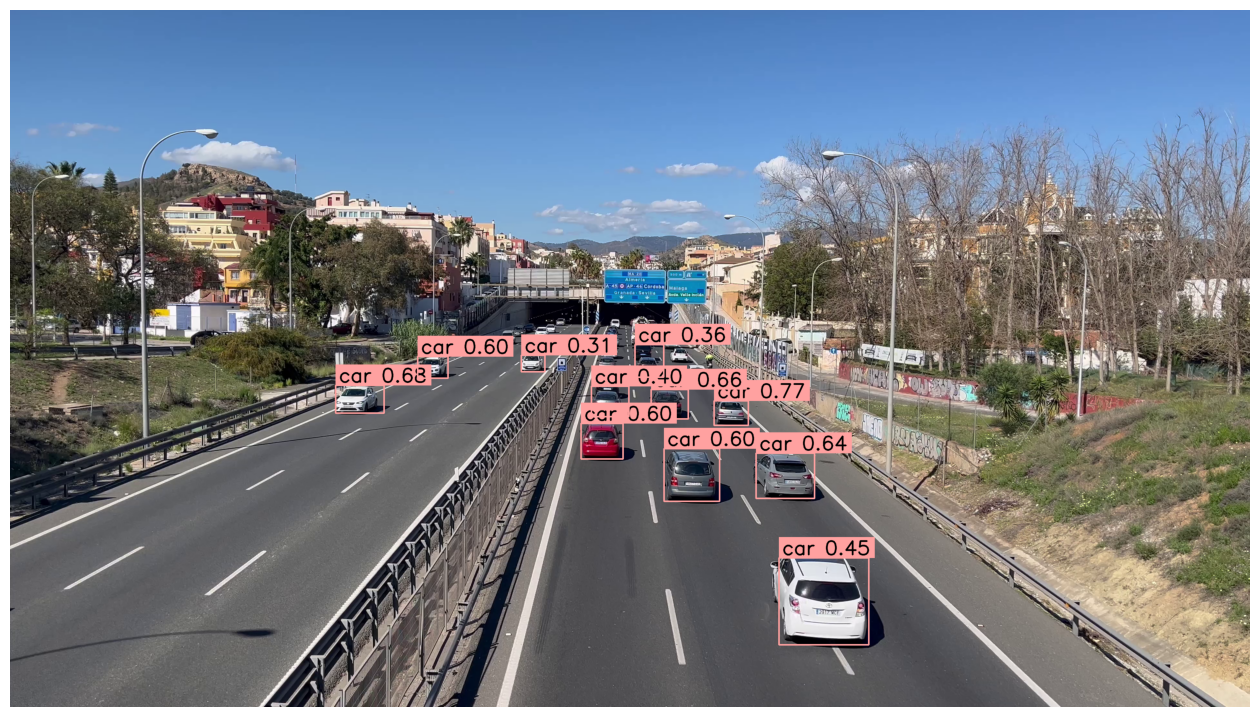

In [ ]:
# create frame generator
generator = sv.get_video_frames_generator(ruta_video)
# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = modelo(frame, verbose=False)[0]

# convert to Detections
detections = sv.Detections.from_ultralytics(results)
# only consider class id from selected_classes define above
detections = detections[np.isin(detections.class_id, selected_classes)]

# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# annotate and display frame
anotated_frame=box_annotator.annotate(scene=frame, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(anotated_frame, (16,16))

<hr style="height:2px;background-color:#de76d2">
<font color='#de76d2' size=4><b>PREDICCION DEL VIDEO</b></font>
<hr style="height:2px;background-color:#de76d2">

In [ ]:
CLASS_NAMES_DICT = modelo.model.names

# class_ids of interest - car, motorcycle, bus and truck
selected_classes = [2, 3, 5, 7]

linea_inicio = sv.Point(50, 1500)
linea_final = sv.Point(3840-50, 1500)

sv.VideoInfo.from_video_path(ruta_video)

VideoInfo(width=3840, height=2160, fps=60, total_frames=629)

In [ ]:
#create BYTRTracker instance
byte_tracker = sv.ByteTrack(track_thresh=0.25, track_buffer=30, match_thresh=0.8, frame_rate=60)

#create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(ruta_video)

#create frame generator
generator = sv.get_video_frames_generator(ruta_video)

#create LineZone instance
line_zone = sv.LineZone(start=linea_inicio, end=linea_final)

#create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)

#create instance of TraceAnnotator
#trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

#create LineZoneAnnotator instance
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

#define call back function to be used in video processing
def callback(frame: np.ndarray, index:int) -> np.ndarray:
  #momdel prediction on single frame and conversion to supervision Detections
  results = modelo(frame, verbose=False)[0]
  detections = sv.Detections.from_ultralytics(results)

  #only consider class id from selected_classes define above
  detections = detections[np.isin(detections.class_id, selected_classes)]

  #tracking detections
  detections = byte_tracker.update_with_detections(detections)
  labels = [
      f"#{tracker_id} {modelo.model.names[class_id]} {confidence:0.2f}"
      for confidence, class_id, tracker_id
      in zip(detections.confidence, detections.class_id, detections.tracker_id)
  ]

  #annotated_frame = trace_annotator.annotate(
  #    scene = frame.copy(),
  #    detections = detections
  #)

  annotated_frame = box_annotator.annotate(
      scene = frame.copy(),
      detections = detections,
      labels = labels)

  #update line counter
  line_zone.trigger(detections)

  #return frame with box and line annotated result
  return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

#process the whole video
sv.process_video(
    source_path = ruta_video,
    target_path = ruta_video_salida,
    callback = callback
)

SupervisionWarnings: `track_buffer` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'lost_track_buffer' instead.
SupervisionWarnings: `track_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'track_activation_threshold' instead.
SupervisionWarnings: `match_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'minimum_matching_threshold' instead.
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
Supe